# Amazon Alexa Review - Sentiment Analysis

Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


### Exploratory Data Analysis

In [3]:
# Load the new electronics product data
data = pd.read_csv("DatafinitiElectronicsProductData.csv")
print(f"Dataset shape : {data.shape}")

Dataset shape : (7299, 27)


In [4]:
data.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,imageURLs,...,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,upc,weight
0,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,True,0.0,5.0,http://reviews.bestbuy.com/3545/4562009/review...,"This keyboard is very easy to type on, but the...",Love the fingerprint reader,JNH1,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds
1,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,True,0.0,4.0,http://reviews.bestbuy.com/3545/4562009/review...,It's thin and light. I can type pretty easily ...,Nice,Appa,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds
2,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,True,0.0,4.0,http://reviews.bestbuy.com/3545/4562009/review...,I love the new design the keys are spaced well...,New,Kman,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds
3,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,True,0.0,5.0,http://reviews.bestbuy.com/3545/4562009/review...,Attached easily and firmly. Has a nice feel. A...,Nice keyboard,UpstateNY,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds
4,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,True,0.0,5.0,http://reviews.bestbuy.com/3545/4562009/review...,"Our original keyboard was okay, but did not ha...",Nice improvement,Glickster,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds


In [5]:
# Check which columns we have available
print(f"Feature names : {data.columns.values}")

# Extract the review text
if 'reviews.text' in data.columns:
    # Create a new column for the text reviews
    data['verified_reviews'] = data['reviews.text']
    
    # Handle missing values
    data.dropna(subset=['verified_reviews'], inplace=True)
    print(f"Dataset shape after dropping null values : {data.shape}")
    
    # Add the length column
    data['length'] = data['verified_reviews'].apply(len)
    
    # Create sentiment labels from ratings
    # Assuming ratings are on a 1-5 scale, where 1-2 are negative and 3-5 are positive
    if 'reviews.rating' in data.columns:
        data['feedback'] = (data['reviews.rating'] >= 3).astype(int)
        print(f"Feedback distribution:\n{data['feedback'].value_counts()}")

Feature names : ['id' 'asins' 'brand' 'categories' 'colors' 'dateAdded' 'dateUpdated'
 'dimension' 'ean' 'imageURLs' 'keys' 'manufacturer' 'manufacturerNumber'
 'name' 'primaryCategories' 'reviews.date' 'reviews.dateSeen'
 'reviews.doRecommend' 'reviews.numHelpful' 'reviews.rating'
 'reviews.sourceURLs' 'reviews.text' 'reviews.title' 'reviews.username'
 'sourceURLs' 'upc' 'weight']
Dataset shape after dropping null values : (7294, 28)
Feedback distribution:
feedback
1    6590
0     704
Name: count, dtype: int64


In [6]:
# Check a sample negative review
neg_review = data[data['feedback'] == 0].iloc[0]['verified_reviews'] if any(data['feedback'] == 0) else "No negative reviews"
print(f"Sample negative review: {neg_review}")

# Check a sample positive review
pos_review = data[data['feedback'] == 1].iloc[0]['verified_reviews'] if any(data['feedback'] == 1) else "No positive reviews"
print(f"Sample positive review: {pos_review}")

Sample negative review: I purchased this for my Surface Pro 4. With facial recognition, this makes the fingerprint scanner on the keyboard unnecessary. The $30 difference could be used elsewhere...like towards the external monitor connector.
Sample positive review: This keyboard is very easy to type on, but the fingerprint reader is the best feature. It is very accurate and simplifies login.


In [7]:
# If using review titles, combine them with the review text
if 'reviews.title' in data.columns:
    data['verified_reviews'] = data['reviews.title'] + ". " + data['verified_reviews']

# If using doRecommend as a target instead of rating
if 'reviews.doRecommend' in data.columns:
    # Handle NaN values by filling them with a default value (e.g., 0)
    data['reviews.doRecommend'] = data['reviews.doRecommend'].fillna(0)
    
    # Convert to integer
    data['feedback_alt'] = data['reviews.doRecommend'].astype(int)
    print(f"Alternative feedback distribution:\n{data['feedback_alt'].value_counts()}")

Alternative feedback distribution:
feedback_alt
1    5401
0    1893
Name: count, dtype: int64


In [8]:
#Check for null values

data.isnull().sum()

id                        0
asins                     0
brand                     0
categories                0
colors                 2019
dateAdded                 0
dateUpdated               0
dimension              1209
ean                    4344
imageURLs                 0
keys                      0
manufacturer           2666
manufacturerNumber        0
name                      0
primaryCategories         0
reviews.date             61
reviews.dateSeen          0
reviews.doRecommend       0
reviews.numHelpful     1481
reviews.rating          164
reviews.sourceURLs        0
reviews.text              0
reviews.title             4
reviews.username          2
sourceURLs                0
upc                       0
weight                    0
verified_reviews          4
length                    0
feedback                  0
feedback_alt              0
dtype: int64

There is one record with no 'verified_reviews' (null value)

In [9]:
#Getting the record where 'verified_reviews' is null 

data[data['verified_reviews'].isna() == True]

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,imageURLs,...,reviews.text,reviews.title,reviews.username,sourceURLs,upc,weight,verified_reviews,length,feedback,feedback_alt
5426,AVpfVI9wilAPnD_xZxH-,B008JJLZ7G,WD,"Computers,Internal Hard Drives,Internal Drives...",NaN,2015-08-16T21:01:50Z,2018-06-05T12:48:22Z,4.0 in x 5.8 in x 1.0 in,NaN,https://i5.walmartimages.com/asr/92471d38-b293...,...,I'm not sure what all i can say about a hard d...,NaN,FiyaFly,http://www.amazon.com/Red-2TB-Hard-Disk-Drive/...,7.180000e+11,1.32 lb,NaN,104,1,0
5439,AVpfVI9wilAPnD_xZxH-,B008JJLZ7G,WD,"Computers,Internal Hard Drives,Internal Drives...",NaN,2015-08-16T21:01:50Z,2018-06-05T12:48:22Z,4.0 in x 5.8 in x 1.0 in,NaN,https://i5.walmartimages.com/asr/92471d38-b293...,...,I have some of these drives in my HP microserv...,NaN,Rob Annable,http://www.amazon.com/Red-2TB-Hard-Disk-Drive/...,7.180000e+11,1.32 lb,NaN,129,1,0
5450,AVpfVI9wilAPnD_xZxH-,B008JJLZ7G,WD,"Computers,Internal Hard Drives,Internal Drives...",NaN,2015-08-16T21:01:50Z,2018-06-05T12:48:22Z,4.0 in x 5.8 in x 1.0 in,NaN,https://i5.walmartimages.com/asr/92471d38-b293...,...,"I love the WD Red line. I have used all sizes,...",NaN,ABoushard,http://www.amazon.com/Red-2TB-Hard-Disk-Drive/...,7.180000e+11,1.32 lb,NaN,159,1,0
5453,AVpfVI9wilAPnD_xZxH-,B008JJLZ7G,WD,"Computers,Internal Hard Drives,Internal Drives...",NaN,2015-08-16T21:01:50Z,2018-06-05T12:48:22Z,4.0 in x 5.8 in x 1.0 in,NaN,https://i5.walmartimages.com/asr/92471d38-b293...,...,Have two of these for my MicroServer - no issu...,NaN,Nitroz,http://www.amazon.com/Red-2TB-Hard-Disk-Drive/...,7.180000e+11,1.32 lb,NaN,122,1,0


In [10]:
#We will drop the null record

data.dropna(inplace=True)

In [11]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (1732, 31)


In [12]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)

In [13]:
data.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,imageURLs,...,reviews.text,reviews.title,reviews.username,sourceURLs,upc,weight,verified_reviews,length,feedback,feedback_alt
0,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,"This keyboard is very easy to type on, but the...",Love the fingerprint reader,JNH1,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds,Love the fingerprint reader. This keyboard is ...,157,1,1
1,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,It's thin and light. I can type pretty easily ...,Nice,Appa,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds,Nice. It's thin and light. I can type pretty e...,58,1,1
2,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,I love the new design the keys are spaced well...,New,Kman,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds,New. I love the new design the keys are spaced...,140,1,1
3,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,Attached easily and firmly. Has a nice feel. A...,Nice keyboard,UpstateNY,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds,Nice keyboard. Attached easily and firmly. Has...,88,1,1
4,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,"Our original keyboard was okay, but did not ha...",Nice improvement,Glickster,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds,Nice improvement. Our original keyboard was ok...,171,1,1


The 'length' column is new generated column - stores the length of 'verified_reviews' for that record. Let's check for some sample records

In [14]:
#Randomly checking for 10th record

print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") #Original value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value: Must have. A must have accessory for the surface pro computer
Length of review : 61
'length' column value : 61


We can see that the length of review is the same as the value in the length column for that record

Datatypes of the features

In [15]:
data.dtypes

id                      object
asins                   object
brand                   object
categories              object
colors                  object
dateAdded               object
dateUpdated             object
dimension               object
ean                    float64
imageURLs               object
keys                    object
manufacturer            object
manufacturerNumber      object
name                    object
primaryCategories       object
reviews.date            object
reviews.dateSeen        object
reviews.doRecommend     object
reviews.numHelpful     float64
reviews.rating         float64
reviews.sourceURLs      object
reviews.text            object
reviews.title           object
reviews.username        object
sourceURLs              object
upc                    float64
weight                  object
verified_reviews        object
length                   int64
feedback                 int64
feedback_alt             int64
dtype: object

* rating, feedback and length are integer values <br>
* date, variation and verified_reviews are string values

### Analyzing 'rating' column

This column refers to the rating of the variation given by the user

In [16]:
len(data)

1732

In [17]:
#Distinct values of 'reviews.rating' and its count  

print(f"Rating value count: \n{data['reviews.rating'].value_counts()}")

Rating value count: 
reviews.rating
5.0    1062
4.0     457
3.0     109
2.0      52
1.0      52
Name: count, dtype: int64


Let's plot the above values in a bar graph

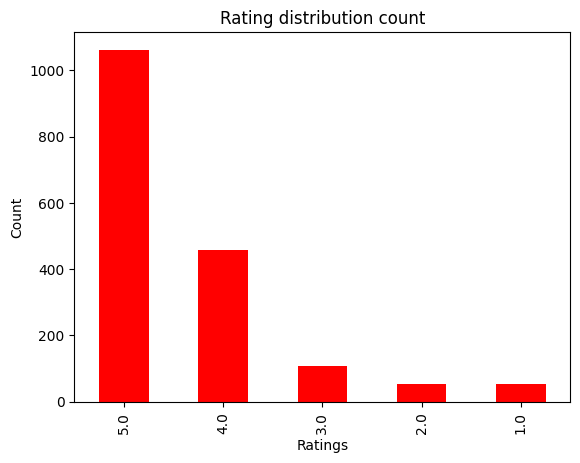

In [18]:
#Bar plot to visualize the total counts of each rating

data['reviews.rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [19]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['reviews.rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
reviews.rating
5.0    61.32
4.0    26.39
3.0     6.29
2.0     3.00
1.0     3.00
Name: count, dtype: float64


Let's plot the above values in a pie chart

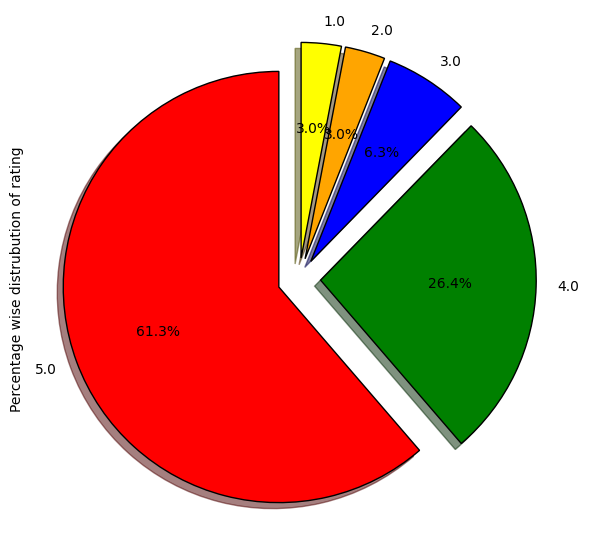

In [20]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['reviews.rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

### Analyzing 'feedback' column

This column refers to the feedback of the verified review

In [21]:
#Distinct values of 'feedback' and its count 

print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    1628
0     104
Name: count, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

feedback value = 0

In [22]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Save your $$$. Don't waste your money on the finger print ID feature. It's great when it works, about 10-20% of the time. Most of the time you just have to sign on like the stupid version keypad, that cost less!


In [23]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Nice. It's thin and light. I can type pretty easily on it.


From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

Let's plot the feedback value count in a bar graph

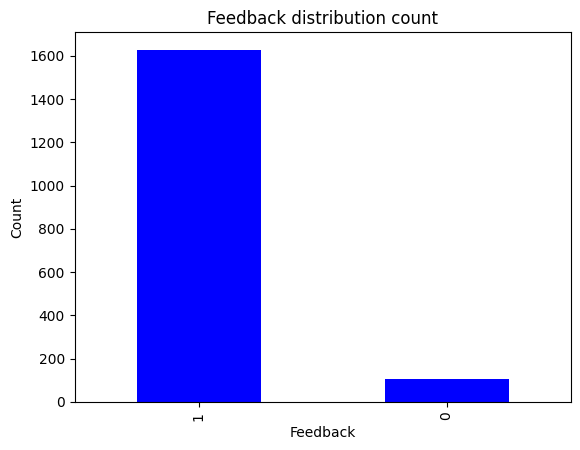

In [24]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [25]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    94.0
0     6.0
Name: count, dtype: float64


Feedback distribution <br>
* 91.87% reviews are positive <br>
* 8.13% reviews are negative

<Axes: ylabel='Percentage wise distrubution of feedback'>

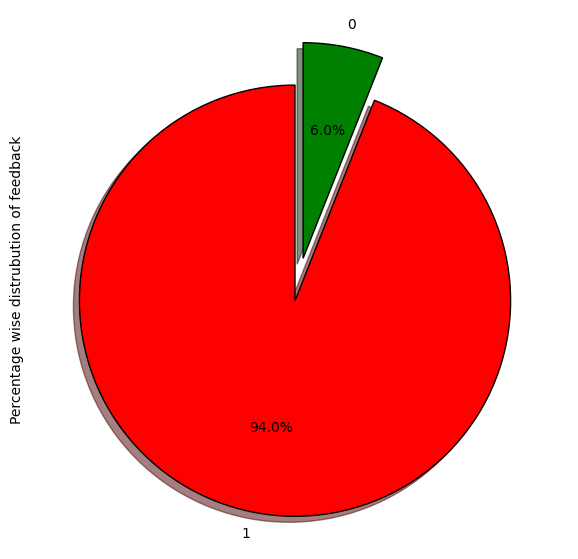

In [26]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

Let's see the 'rating' values for different values of 'feedback'

In [27]:
data[data['feedback'] == 0]['reviews.rating'].value_counts()

reviews.rating
2.0    52
1.0    52
Name: count, dtype: int64

In [28]:
data[data['feedback'] == 1]['reviews.rating'].value_counts()

reviews.rating
5.0    1062
4.0     457
3.0     109
Name: count, dtype: int64

##### If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

### Analyzing 'variation' column

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

In [29]:
# #Distinct values of 'variation' and its count 

# print(f"Variation value count: \n{data['variation'].value_counts()}")

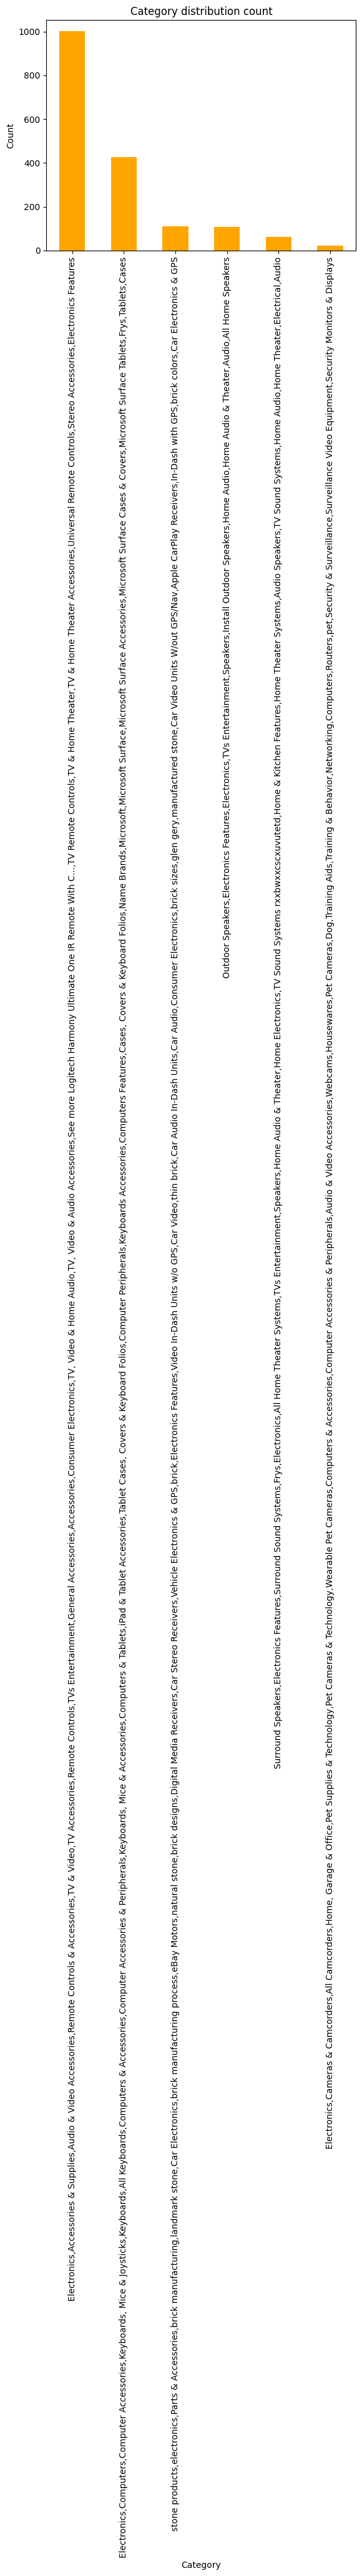

In [30]:
#Bar graph to visualize the total counts of each category

data['categories'].value_counts().plot.bar(color = 'orange')
plt.title('Category distribution count')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [31]:
# Check if the 'variation' column exists in the DataFrame
if 'variation' in data.columns:
	# Finding the percentage distribution of each variation
	print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")
else:
	print("The 'variation' column does not exist in the DataFrame.")

The 'variation' column does not exist in the DataFrame.


Mean rating according to variation

In [32]:
# Check if the 'variation' column exists in the DataFrame
if 'variation' in data.columns:
	result = data.groupby('variation')['reviews.rating'].mean()
	print(result)
else:
	print("The 'variation' column does not exist in the DataFrame.")

The 'variation' column does not exist in the DataFrame.


Let's analyze the above ratings

In [33]:
# Check if the 'variation' column exists in the DataFrame
if 'variation' in data.columns:
	data.groupby('variation')['reviews.rating'].mean().sort_values().plot.bar(color='brown', figsize=(11, 6))
	plt.title("Mean rating according to variation")
	plt.xlabel('Variation')
	plt.ylabel('Mean rating')
	plt.show()
else:
	print("The 'variation' column does not exist in the DataFrame.")

The 'variation' column does not exist in the DataFrame.


### Analyzing 'verified_reviews' column

This column contains the textual review given by the user for a variation for the product.

In [34]:
data['length'].describe()

count    1732.000000
mean      238.723441
std       231.348313
min        49.000000
25%       106.000000
50%       165.000000
75%       275.250000
max      2876.000000
Name: length, dtype: float64

Length analysis for full dataset

[Text(0.5, 1.0, 'Distribution of length of review ')]

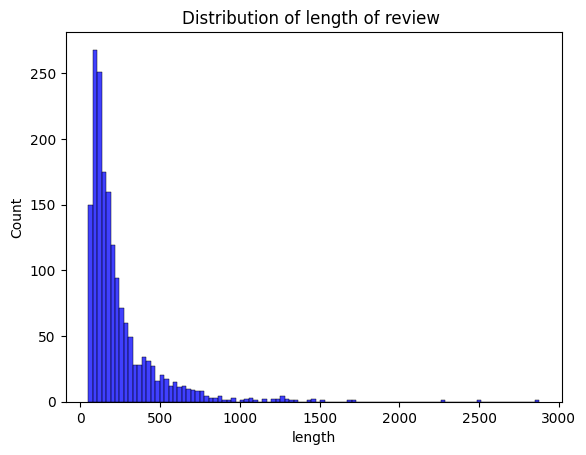

In [35]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

Length analysis when feedback is 0 (negative)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

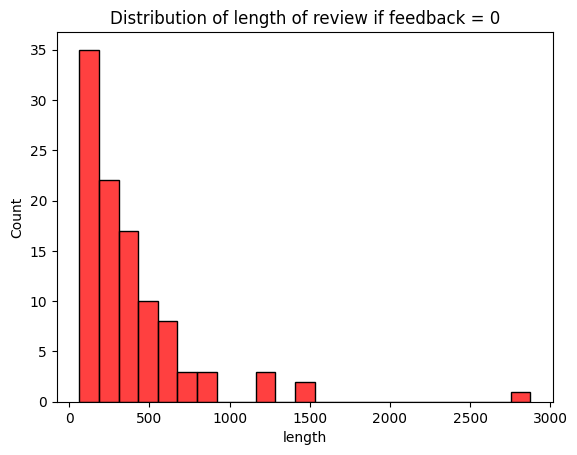

In [36]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

Length analysis when feedback is 1 (positive)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

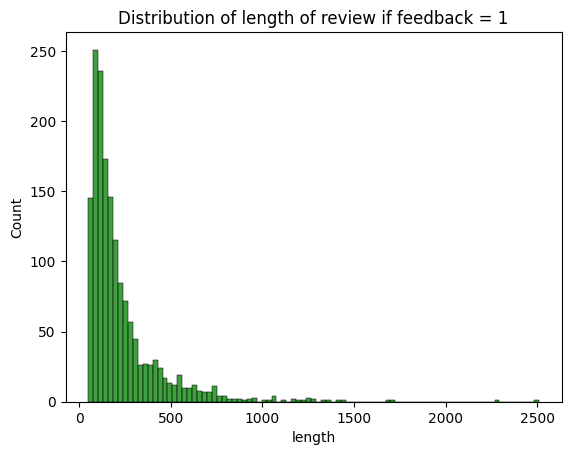

In [37]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

Lengthwise mean rating

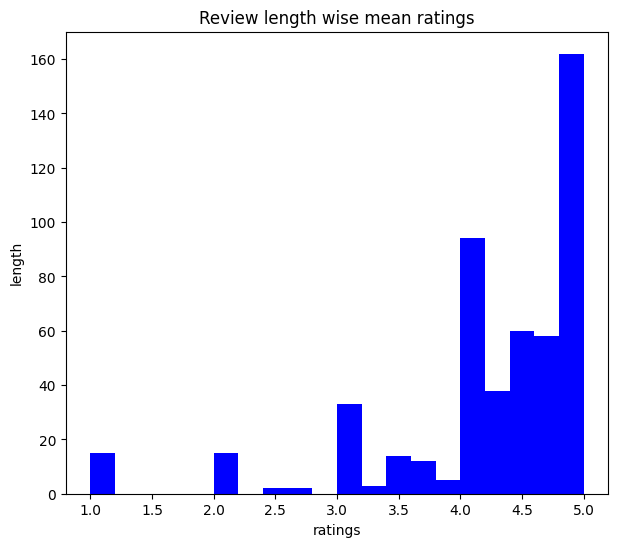

In [38]:
# Fix the syntax error by separating the commands
data.groupby('length')['reviews.rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title("Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [39]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

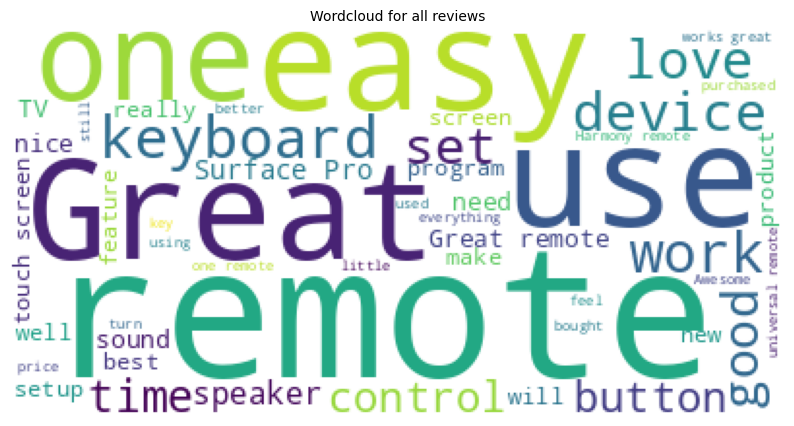

In [40]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

Lets find the unique words in each feedback category

In [41]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


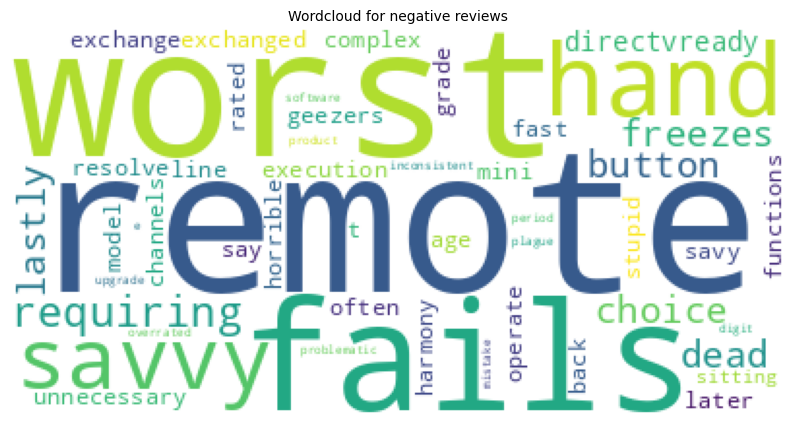

In [42]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

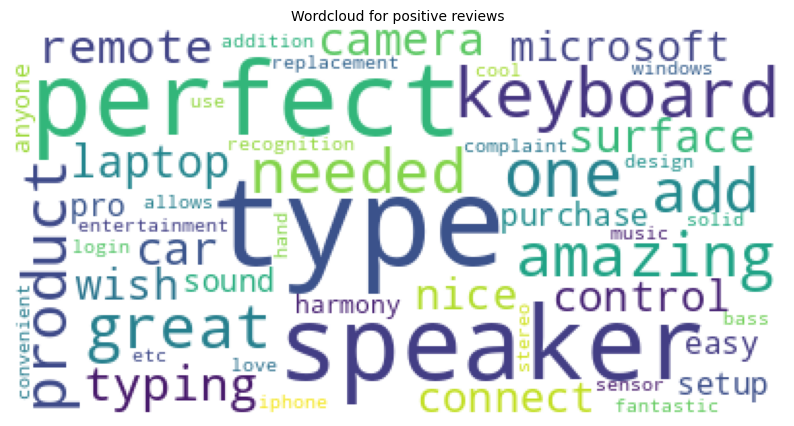

In [43]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [44]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to create bag of words

In [45]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [46]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

Checking the shape of X and y

In [47]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1732, 2500)
y shape: (1732,)


Splitting data into train and test set with 30% data with testing.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (1212, 2500)
y train: (1212,)
X test: (520, 2500)
y test: (520,)


In [49]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 14
X test max value: 10


We'll scale X_train and X_test so that all values are between 0 and 1.

In [50]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [51]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

#### Random Forest

In [52]:
# For RandomForest example
model_rf = RandomForestClassifier(class_weight='balanced')
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier(class_weight='balanced')

In [53]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 1.0
Testing Accuracy : 0.9384615384615385


In [54]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [55]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

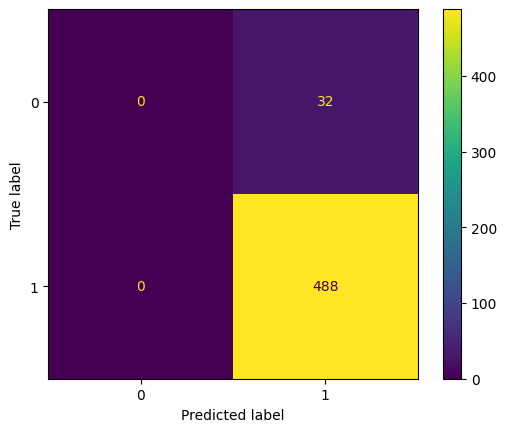

In [56]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross-validation

In [57]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9406042541661022
Standard Variance : 0.0030890123289526892


Applying grid search to get the optimal parameters on random forest

In [58]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [59]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [60]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 12, 'n_estimators': 100}


In [61]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 99.94843234323433
Cross validation mean accuracy on test set : 94.20379537953795
Accuracy score for test set : 0.9384615384615385


#### XgBoost

In [62]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [63]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.995049504950495
Testing Accuracy : 0.9365384615384615


In [64]:
y_preds = model_xgb.predict(X_test)

In [65]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[  2  30]
 [  3 485]]


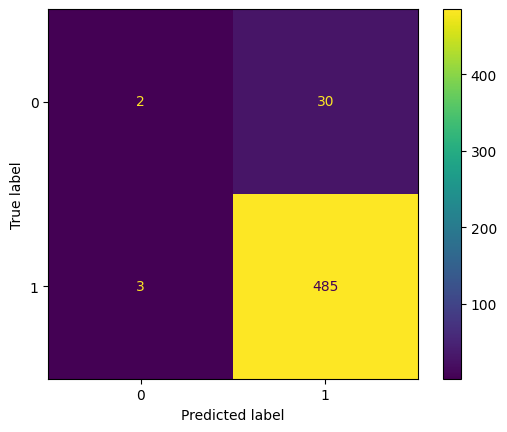

In [66]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [67]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

#### Decision Tree Classifier

In [68]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [69]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 1.0
Testing Accuracy : 0.9096153846153846


In [70]:
y_preds = model_dt.predict(X_test)

In [71]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 13  19]
 [ 59 429]]


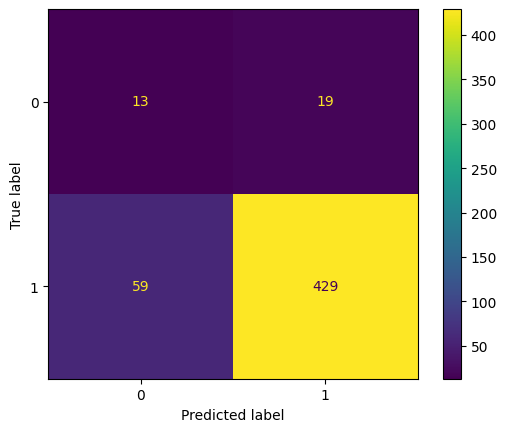

In [72]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()